In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Use CPU only to avoid GPU-related import errors
device = torch.device("cpu")

# ------------------------
# Data Preprocessing
# ------------------------

# Load orientation data (path provided by user)
ori_path = "DC3_final_530km_3_month_with_slew_15sbins_EarthLocal.ori"
ori_df = pd.read_csv(
    ori_path,
    delim_whitespace=True,
    skiprows=1,
    header=None,
    names=["prefix", "timestamp", "x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
)
ori_df = ori_df.drop(columns=["prefix"])
ori_df["timestamp"] = pd.to_datetime(ori_df["timestamp"], unit='s')

# Load detector data
time_array = np.load("time_array.npy")
rates = np.squeeze(np.load("total_rates.npy"))
time_series = pd.to_datetime(time_array, unit='s')
rates_df = pd.DataFrame(rates, columns=[f"detector_{i+1}" for i in range(rates.shape[1])])
rates_df["timestamp"] = time_series



C:\Users\mikec\AppData\Local\Temp\ipykernel_13368\3250813714.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ori_df = pd.read_csv(


(5761, 7)
(2640, 7)


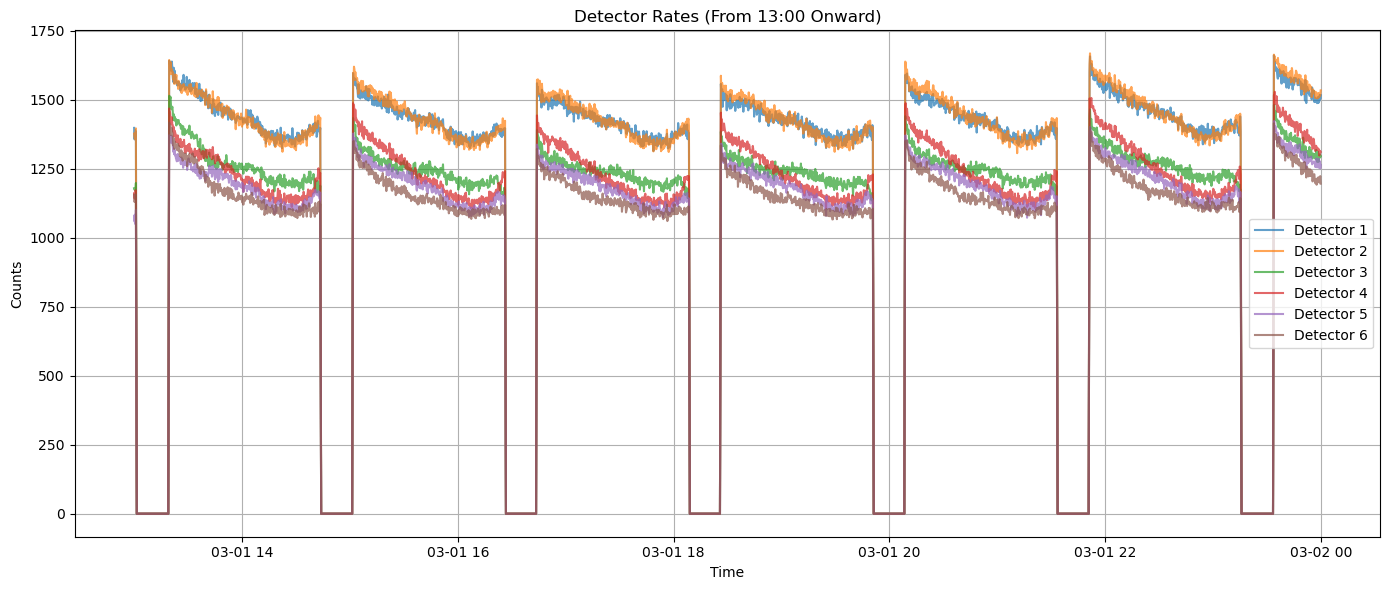

In [2]:
# Filter all days from 13:00 to 00:00
print(rates_df.shape)
rates_df = rates_df[rates_df["timestamp"].dt.hour >= 13]
print(rates_df.shape)
# Plot all 6 detectors after filtering to 13:00 onward
plt.figure(figsize=(14, 6))
for i in range(1, 7):
    plt.plot(rates_df["timestamp"], rates_df[f"detector_{i}"], label=f"Detector {i}", alpha=0.7)

plt.title("Detector Rates (From 13:00 Onward)")
plt.xlabel("Time")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ori_df = ori_df.dropna(subset=["timestamp"])

In [3]:
# Merge orientation with detector data
merged_df = pd.merge_asof(
    rates_df.sort_values("timestamp"),
    ori_df.sort_values("timestamp"),
    on="timestamp"
).dropna()

In [4]:
merged_df["hour"] = merged_df["timestamp"].dt.hour + merged_df["timestamp"].dt.minute / 60
#merged_df["sin_time"] = np.sin(2 * np.pi * merged_df["hour"] / 24)
##erged_df["cos_time"] = np.cos(2 * np.pi * merged_df["hour"] / 24)


In [5]:
# Parameters
WINDOW_SIZE = 10
EPOCHS = 200
learning_rate= 1e-3#5*1e-5
epochs_no_improve = 10
early_stopping_patience = 10

def create_windowed_data(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i - window_size:i].flatten())  # flatten the window
        y_seq.append(y[i])  # predict current target
    return np.array(X_seq), np.array(y_seq)

In [6]:
# Extract features and targets again from merged_df
orientation_features = ["x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
#time_features = ["sin_time", "cos_time"]
feature_cols = orientation_features# + time_features
target_cols = [col for col in merged_df.columns if col.startswith("detector_")]

X_all = merged_df[feature_cols].values
y_all = merged_df[target_cols].values

# Normalize features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

y_scaler = StandardScaler()
y_all_scaled = y_scaler.fit_transform(y_all)

# Create windowed sequences again with scaled y
X_seq, y_seq = create_windowed_data(X_all_scaled, y_all_scaled, WINDOW_SIZE)

In [7]:
# Create windowed sequences again with scaled y
X_seq, y_seq = create_windowed_data(X_all_scaled, y_all_scaled, WINDOW_SIZE)

# Split again
split_index = int(len(X_seq) * 0.7)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

In [8]:
# Dataset and model
class WindowedDetectorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(WindowedDetectorDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
test_loader = DataLoader(WindowedDetectorDataset(X_test_seq, y_test_seq), batch_size=64, shuffle=False)

class FeedforwardWindowed(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, output_dim)
        self.log_sigma = nn.Linear(32, output_dim)

    def forward(self, x):
        h = self.model(x)
        mu = self.mu(h)
        sigma = torch.exp(self.log_sigma(h))
        #sigma = torch.clamp(sigma, min=1e-3)
        return mu, sigma

# Loss and training
def gaussian_nll(y_true, mu, sigma):
    return torch.mean(0.5 * torch.log(2 * torch.pi * sigma ** 2) + 0.5 * ((y_true - mu) ** 2) / (sigma ** 2))

In [9]:
# Redefine datasets and loaders
train_loader = DataLoader(WindowedDetectorDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
test_loader = DataLoader(WindowedDetectorDataset(X_test_seq, y_test_seq), batch_size=64, shuffle=False)

In [12]:
# Retrain the model with same architecture
model = FeedforwardWindowed(X_train_seq.shape[1], y_train_seq.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
best_loss = float('inf')
best_model_path = "best_model.pt"

losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        mu, sigma = model(xb)
        sigma = torch.clamp(sigma, min=1e-3)
        loss = gaussian_nll(yb, mu, sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    losses.append(mean_loss)
    print(f"Epoch {epoch+1}: Loss = {mean_loss:.4f}")

    # Early stopping logic
    if mean_loss < best_loss - 1e-4:  # a small delta to avoid noise
        best_loss = mean_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model.")

# Load best model after training
model.load_state_dict(torch.load(best_model_path))

Epoch 1: Loss = 1.0822
Saved best model.
Epoch 2: Loss = -0.1974
Saved best model.
Epoch 3: Loss = -0.8365
Saved best model.
Epoch 4: Loss = -1.0991
Saved best model.
Epoch 5: Loss = -1.2316
Saved best model.
Epoch 6: Loss = -1.3445
Saved best model.
Epoch 7: Loss = -1.4201
Saved best model.
Epoch 8: Loss = -1.5408
Saved best model.
Epoch 9: Loss = -1.5594
Saved best model.
Epoch 10: Loss = -1.4347
Epoch 11: Loss = -1.5891
Saved best model.
Epoch 12: Loss = -1.6435
Saved best model.
Epoch 13: Loss = -1.5462
Epoch 14: Loss = -1.5479
Epoch 15: Loss = -1.6232
Epoch 16: Loss = -1.7011
Saved best model.
Epoch 17: Loss = -1.7505
Saved best model.
Epoch 18: Loss = -1.7238
Epoch 19: Loss = -1.7678
Saved best model.
Epoch 20: Loss = -1.8273
Saved best model.
Epoch 21: Loss = -1.7989
Epoch 22: Loss = -1.5860
Epoch 23: Loss = -1.5735
Epoch 24: Loss = -1.6916
Epoch 25: Loss = -1.8412
Saved best model.
Epoch 26: Loss = -1.7563
Epoch 27: Loss = -1.8598
Saved best model.
Epoch 28: Loss = -1.7588
Epoc

C:\Users\mikec\AppData\Local\Temp\ipykernel_13368\3345751514.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [14]:
# Evaluate
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    mu_pred, sigma_pred = model(X_test_tensor)
    mu_pred = mu_pred.cpu().numpy()
    sigma_pred = sigma_pred.cpu().numpy()

# Invert scaling of predictions and targets
mu_pred_inv = y_scaler.inverse_transform(mu_pred)
y_test_inv = y_scaler.inverse_transform(y_test_seq)
sigma_pred_inv = sigma_pred * y_scaler.scale_  # approximate inverse scaling

# Compute MSE
mse = mean_squared_error(y_test_inv, mu_pred_inv)
print(f"\nWindowed MSE on test (30% holdout, normalized target): {mse:.4f}")




Windowed MSE on test (30% holdout, normalized target): 3492.2461


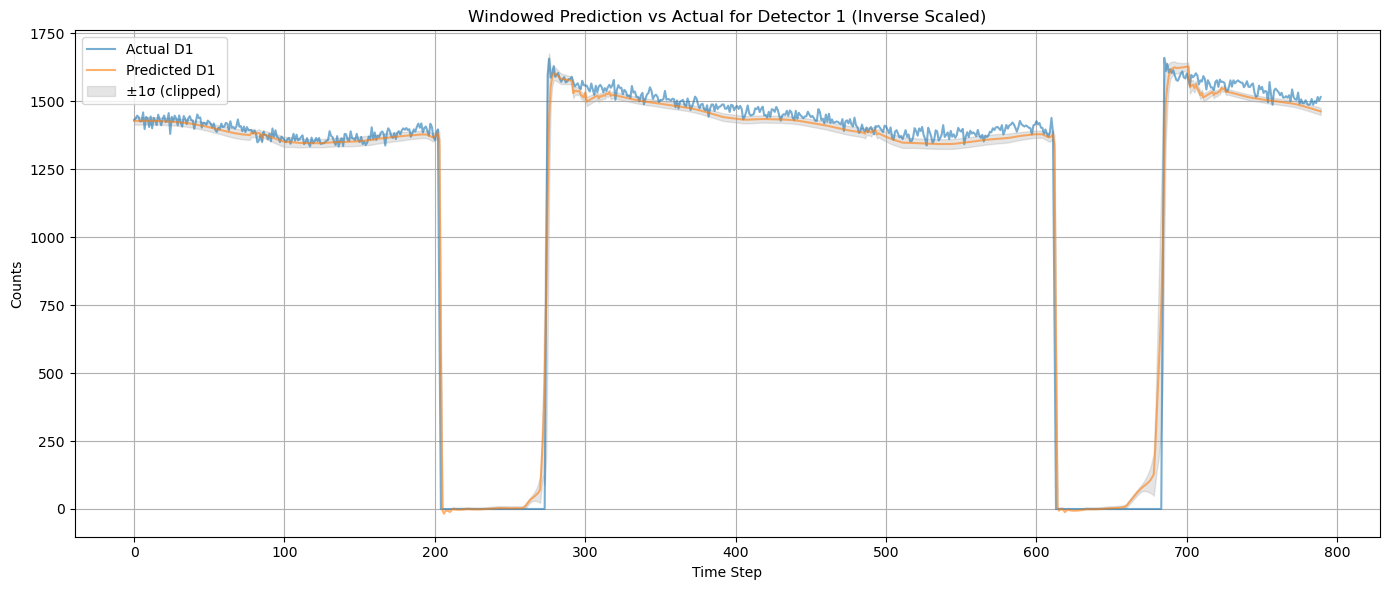

In [ ]:
# Plot predictions for Detector 1

x_range = np.arange(len(mu_pred_inv))
plt.figure(figsize=(14, 6))
plt.plot(x_range, y_test_inv[:, 0], label="Actual D1", alpha=0.6)
plt.plot(x_range, mu_pred_inv[:, 0], label="Predicted D1", alpha=0.6)
lower_bound = np.clip(mu_pred_inv[:, 0] - sigma_pred_inv[:, 0], a_min=0, a_max=2000)
upper_bound = np.clip(mu_pred_inv[:, 0] + sigma_pred_inv[:, 0], a_min=0, a_max=2000)

plt.fill_between(
    x_range,
    lower_bound,
    upper_bound,
    color='gray', alpha=0.2, label="±1σ (clipped)"
)
plt.title("Windowed Prediction vs Actual for Detector 1 (Inverse Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Counts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Removing the 0 counts  
To improve the prediction at the edges let's remove the windows of data with 0 count.

In [15]:
# Remove all rows from merged_df where any detector column has a 0 count
merged_df_no_zeros = merged_df[(merged_df[target_cols] != 0).all(axis=1)]
print(f"Original shape: {merged_df.shape}, After removing zeros: {merged_df_no_zeros.shape}")

Original shape: (2640, 15), After removing zeros: (2153, 15)


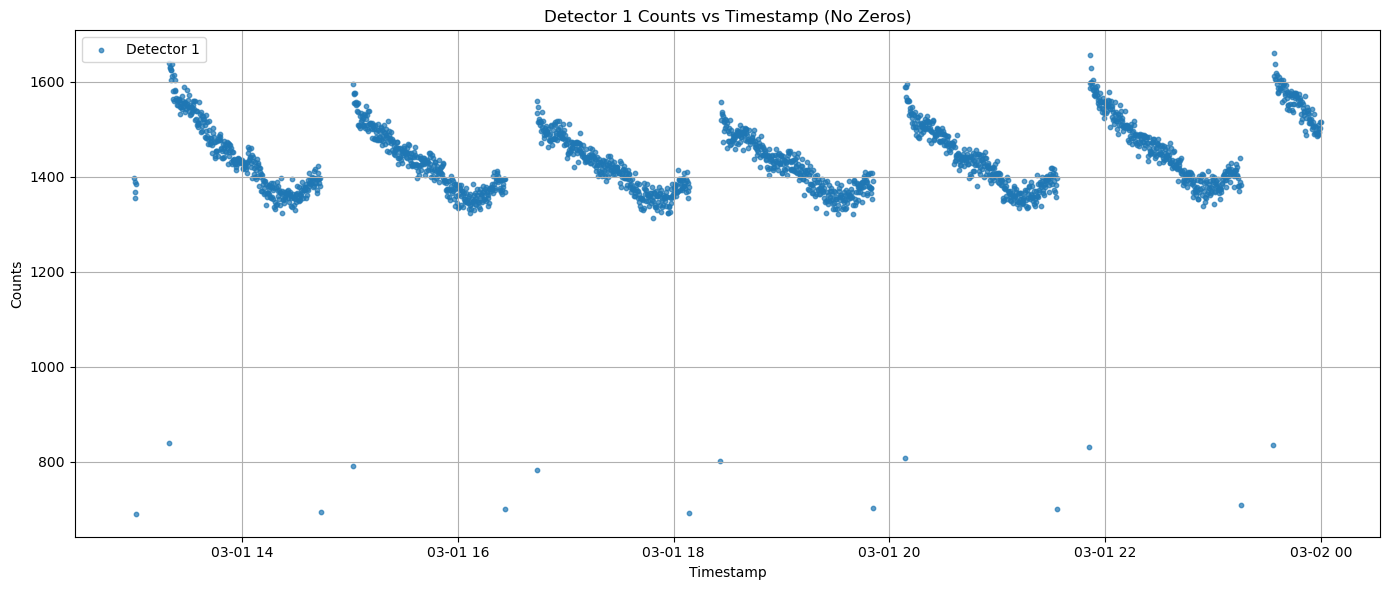

In [ ]:
plt.figure(figsize=(14, 6))
plt.scatter(merged_df_no_zeros["timestamp"], merged_df_no_zeros["detector_1"], label="Detector 1", s=10, alpha=0.7)
plt.title("Detector 1 Counts vs Timestamp (No Zeros)")
plt.xlabel("Timestamp")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
X_all = merged_df_no_zeros[feature_cols].values
y_all = merged_df_no_zeros[target_cols].values

# Normalize features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

y_scaler = StandardScaler()
y_all_scaled = y_scaler.fit_transform(y_all)

# Create windowed sequences again with scaled y
X_seq, y_seq = create_windowed_data(X_all_scaled, y_all_scaled, WINDOW_SIZE)

In [ ]:
# Split again
split_index = int(len(X_seq) * 0.7)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

In [ ]:
# Redefine datasets and loaders
train_loader = DataLoader(WindowedDetectorDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
test_loader = DataLoader(WindowedDetectorDataset(X_test_seq, y_test_seq), batch_size=64, shuffle=False)

In [ ]:
# Retrain the model with same architecture
model = FeedforwardWindowed(X_train_seq.shape[1], y_train_seq.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
best_loss = float('inf')
best_model_path = "best_model.pt"

losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        mu, sigma = model(xb)
        sigma = torch.clamp(sigma, min=1e-3)
        loss = gaussian_nll(yb, mu, sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    losses.append(mean_loss)
    print(f"Epoch {epoch+1}: Loss = {mean_loss:.4f}")

    # Early stopping logic
    if mean_loss < best_loss - 1e-4:  # a small delta to avoid noise
        best_loss = mean_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model.")

# Load best model after training
model.load_state_dict(torch.load(best_model_path))

Epoch 1: Loss = 1.2381
Saved best model.
Epoch 2: Loss = 0.7526
Saved best model.
Epoch 3: Loss = 0.1775
Saved best model.
Epoch 4: Loss = -0.1161
Saved best model.
Epoch 5: Loss = -0.2102
Saved best model.
Epoch 6: Loss = -0.2679
Saved best model.
Epoch 7: Loss = -0.2908
Saved best model.
Epoch 8: Loss = -0.3047
Saved best model.
Epoch 9: Loss = -0.3395
Saved best model.
Epoch 10: Loss = -0.3510
Saved best model.
Epoch 11: Loss = -0.3657
Saved best model.
Epoch 12: Loss = -0.3814
Saved best model.
Epoch 13: Loss = -0.3900
Saved best model.
Epoch 14: Loss = -0.3780
Epoch 15: Loss = -0.3870
Epoch 16: Loss = -0.3900
Epoch 17: Loss = -0.3770
Epoch 18: Loss = -0.3974
Saved best model.
Epoch 19: Loss = -0.4140
Saved best model.
Epoch 20: Loss = -0.4070
Epoch 21: Loss = -0.4205
Saved best model.
Epoch 22: Loss = -0.4370
Saved best model.
Epoch 23: Loss = -0.4353
Epoch 24: Loss = -0.4256
Epoch 25: Loss = -0.4366
Epoch 26: Loss = -0.4472
Saved best model.
Epoch 27: Loss = -0.4504
Saved best mo

C:\Users\mikec\AppData\Local\Temp\ipykernel_21160\3345751514.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [ ]:
# Evaluate
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    mu_pred, sigma_pred = model(X_test_tensor)
    mu_pred = mu_pred.cpu().numpy()
    sigma_pred = sigma_pred.cpu().numpy()

# Invert scaling of predictions and targets
mu_pred_inv = y_scaler.inverse_transform(mu_pred)
y_test_inv = y_scaler.inverse_transform(y_test_seq)
sigma_pred_inv = sigma_pred * y_scaler.scale_  # approximate inverse scaling

# Compute MSE
mse = mean_squared_error(y_test_inv, mu_pred_inv)
print(f"\nWindowed MSE on test (30% holdout, normalized target): {mse:.4f}")


Windowed MSE on test (30% holdout, normalized target): 1665.0828


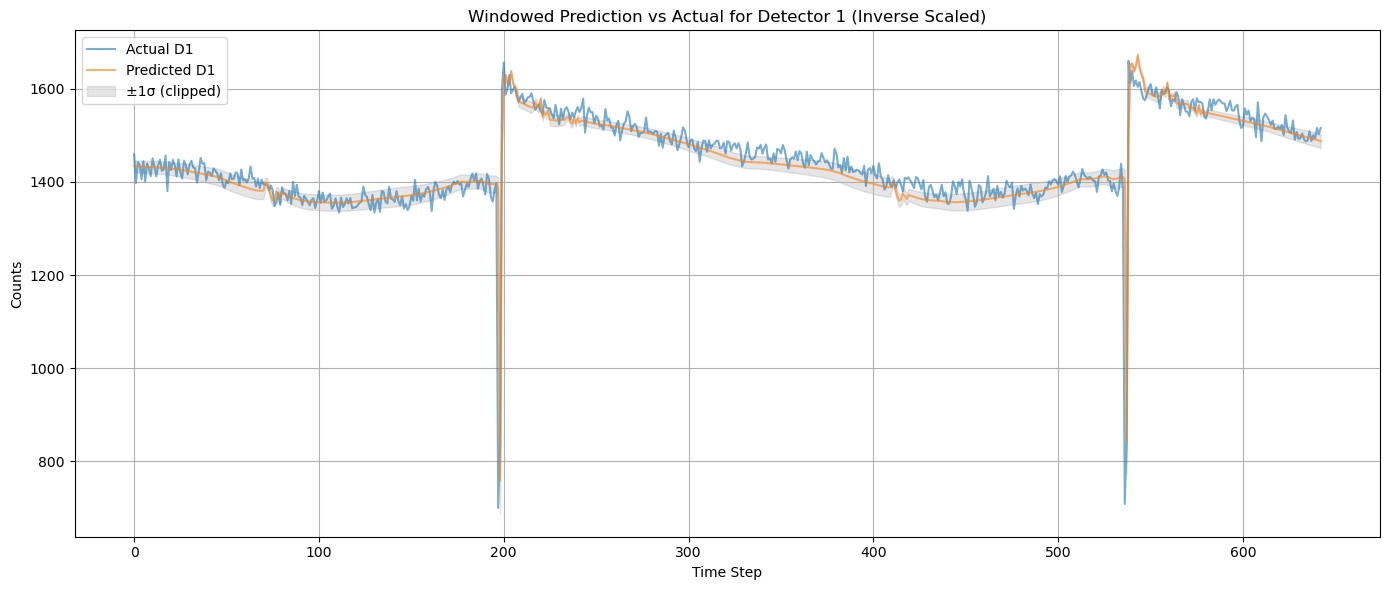

In [ ]:
# Plot predictions for Detector 1

x_range = np.arange(len(mu_pred_inv))
plt.figure(figsize=(14, 6))
plt.plot(x_range, y_test_inv[:, 0], label="Actual D1", alpha=0.6)
plt.plot(x_range, mu_pred_inv[:, 0], label="Predicted D1", alpha=0.6)
lower_bound = np.clip(mu_pred_inv[:, 0] - sigma_pred_inv[:, 0], a_min=0, a_max=2000)
upper_bound = np.clip(mu_pred_inv[:, 0] + sigma_pred_inv[:, 0], a_min=0, a_max=2000)

plt.fill_between(
    x_range,
    lower_bound,
    upper_bound,
    color='gray', alpha=0.2, label="±1σ (clipped)"
)
plt.title("Windowed Prediction vs Actual for Detector 1 (Inverse Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Counts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Removing values around 800  
The detections signals around 800, which are exactly one before and after adjusting satellite's position, are likely worsening the prediction at the edges.

In [16]:
# Remove all rows where any detector column has a count lower than 1000
merged_df_clean = merged_df_no_zeros[(merged_df_no_zeros[target_cols] >= 1000).all(axis=1)]
print(f"Original shape: {merged_df_no_zeros.shape}, After removing <1000: {merged_df_clean.shape}")

Original shape: (2153, 15), After removing <1000: (2139, 15)


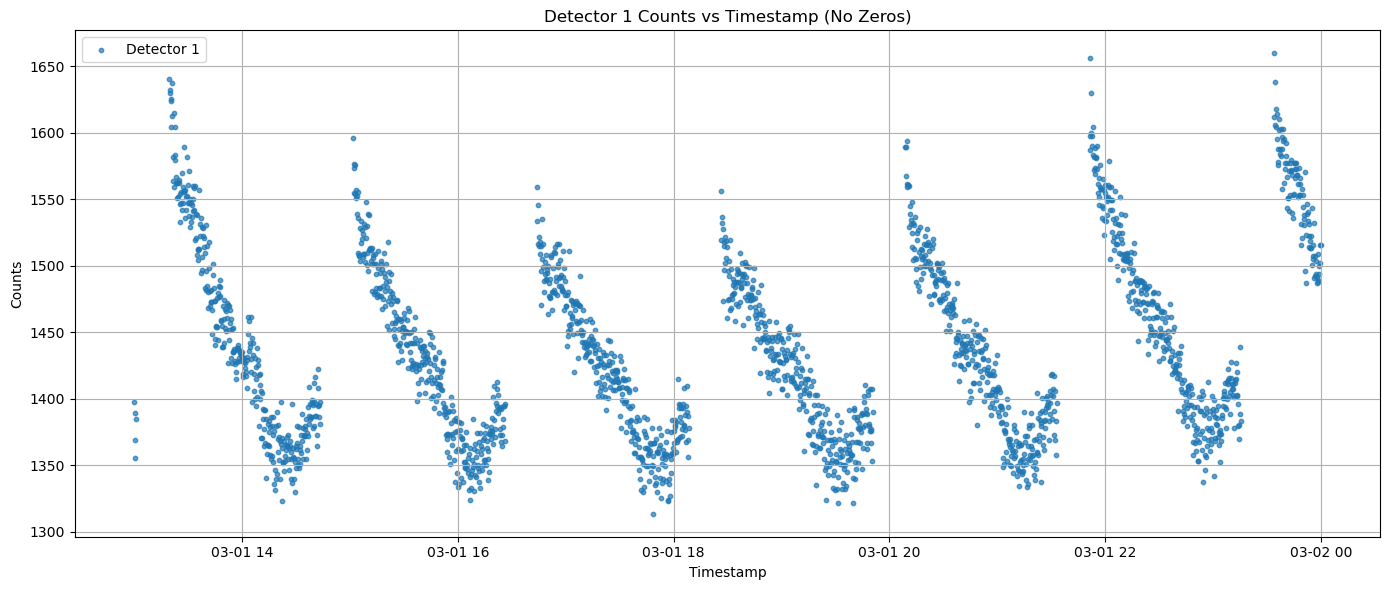

In [17]:
plt.figure(figsize=(14, 6))
plt.scatter(merged_df_clean["timestamp"], merged_df_clean["detector_1"], label="Detector 1", s=10, alpha=0.7)
plt.title("Detector 1 Counts vs Timestamp (No Zeros)")
plt.xlabel("Timestamp")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
X_all = merged_df_clean[feature_cols].values
y_all = merged_df_clean[target_cols].values

# Normalize features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

y_scaler = StandardScaler()
y_all_scaled = y_scaler.fit_transform(y_all)

# Create windowed sequences again with scaled y
X_seq, y_seq = create_windowed_data(X_all_scaled, y_all_scaled, WINDOW_SIZE)

# Split again
split_index = int(len(X_seq) * 0.7)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

# Redefine datasets and loaders
train_loader = DataLoader(WindowedDetectorDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
test_loader = DataLoader(WindowedDetectorDataset(X_test_seq, y_test_seq), batch_size=64, shuffle=False)

# Retrain the model with same architecture
model = FeedforwardWindowed(X_train_seq.shape[1], y_train_seq.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
best_loss = float('inf')
best_model_path = "best_model.pt"

losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        mu, sigma = model(xb)
        sigma = torch.clamp(sigma, min=1e-3)
        loss = gaussian_nll(yb, mu, sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    losses.append(mean_loss)
    print(f"Epoch {epoch+1}: Loss = {mean_loss:.4f}")

    # Early stopping logic
    if mean_loss < best_loss - 1e-4:  # a small delta to avoid noise
        best_loss = mean_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model.")

# Load best model after training
model.load_state_dict(torch.load(best_model_path))

Epoch 1: Loss = 1.2128
Saved best model.
Epoch 2: Loss = 0.5289
Saved best model.
Epoch 3: Loss = 0.0749
Saved best model.
Epoch 4: Loss = -0.0374
Saved best model.
Epoch 5: Loss = -0.0875
Saved best model.
Epoch 6: Loss = -0.1088
Saved best model.
Epoch 7: Loss = -0.1416
Saved best model.
Epoch 8: Loss = -0.1713
Saved best model.
Epoch 9: Loss = -0.1548
Epoch 10: Loss = -0.2032
Saved best model.
Epoch 11: Loss = -0.1841
Epoch 12: Loss = -0.2137
Saved best model.
Epoch 13: Loss = -0.2251
Saved best model.
Epoch 14: Loss = -0.2303
Saved best model.
Epoch 15: Loss = -0.2430
Saved best model.
Epoch 16: Loss = -0.2312
Epoch 17: Loss = -0.2246
Epoch 18: Loss = -0.2140
Epoch 19: Loss = -0.2340
Epoch 20: Loss = -0.2554
Saved best model.
Epoch 21: Loss = -0.2489
Epoch 22: Loss = -0.2578
Saved best model.
Epoch 23: Loss = -0.2711
Saved best model.
Epoch 24: Loss = -0.2571
Epoch 25: Loss = -0.2637
Epoch 26: Loss = -0.2654
Epoch 27: Loss = -0.2764
Saved best model.
Epoch 28: Loss = -0.2636
Epoch 

C:\Users\mikec\AppData\Local\Temp\ipykernel_13368\3345751514.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [20]:
# Evaluate
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    mu_pred, sigma_pred = model(X_test_tensor)
    mu_pred = mu_pred.cpu().numpy()
    sigma_pred = sigma_pred.cpu().numpy()

# Invert scaling of predictions and targets
mu_pred_inv = y_scaler.inverse_transform(mu_pred)
y_test_inv = y_scaler.inverse_transform(y_test_seq)
sigma_pred_inv = sigma_pred * y_scaler.scale_  # approximate inverse scaling

# Compute MSE
mse = mean_squared_error(y_test_inv, mu_pred_inv)
print(f"\nWindowed MSE on test (30% holdout, normalized target): {mse:.4f}")


Windowed MSE on test (30% holdout, normalized target): 598.6659


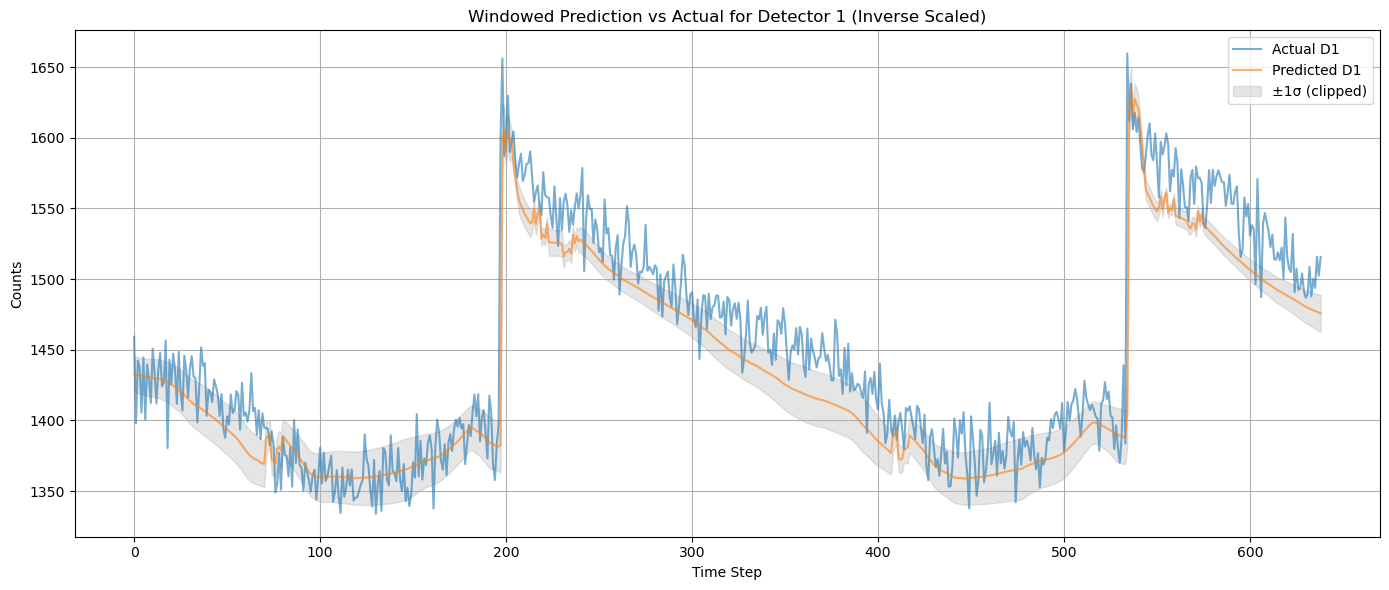

In [21]:
# Plot predictions for Detector 1

x_range = np.arange(len(mu_pred_inv))
plt.figure(figsize=(14, 6))
plt.plot(x_range, y_test_inv[:, 0], label="Actual D1", alpha=0.6)
plt.plot(x_range, mu_pred_inv[:, 0], label="Predicted D1", alpha=0.6)
lower_bound = np.clip(mu_pred_inv[:, 0] - sigma_pred_inv[:, 0], a_min=0, a_max=2000)
upper_bound = np.clip(mu_pred_inv[:, 0] + sigma_pred_inv[:, 0], a_min=0, a_max=2000)

plt.fill_between(
    x_range,
    lower_bound,
    upper_bound,
    color='gray', alpha=0.2, label="±1σ (clipped)"
)
plt.title("Windowed Prediction vs Actual for Detector 1 (Inverse Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Counts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Let's now plot a histogram of the reconstruction errors.

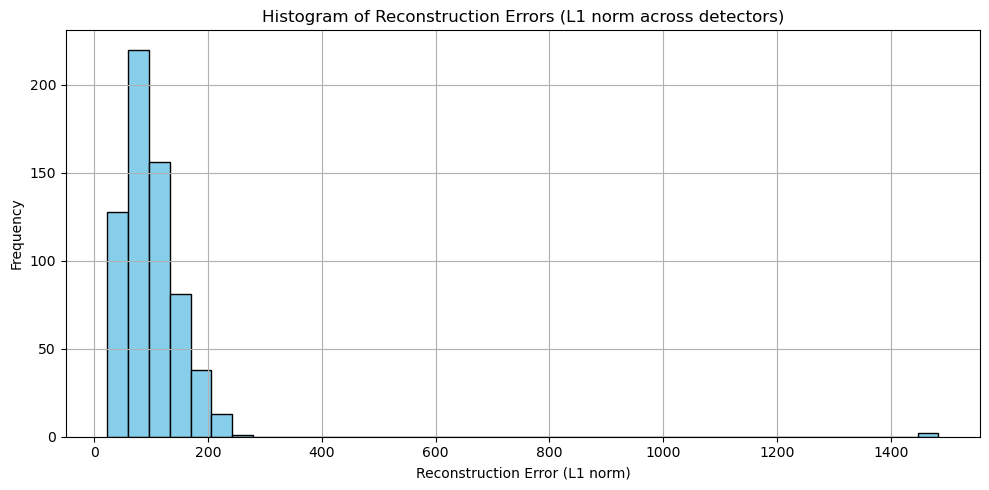

In [23]:
# Compute reconstruction errors (L1 norm per sample, for all detectors)
reconstruction_errors = np.sum(np.abs(mu_pred_inv - y_test_inv), axis=1)

plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=40, color='skyblue', edgecolor='black')
plt.title("Histogram of Reconstruction Errors (L1 norm across detectors)")
plt.xlabel("Reconstruction Error (L1 norm)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()